<a href="https://colab.research.google.com/github/AamirAlam/Remote-sensing/blob/main/aligarh_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
import skimage.draw


# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

In [ ]:
import tensorflow as tf

tf.test.is_gpu_available( cuda_only=False, min_cuda_compute_capability=None)

True

## Configurations

In [ ]:
class AerialConfig(Config):
    """Configuration for training on the toy  dataset.
    Derives from the base Config class and overrides some values.
    """
    # Give the configuration a recognizable name
    NAME = "aerial"

    # We use a GPU with 12GB memory, which can fit two images.
    # Adjust down if you use a smaller GPU.
    IMAGES_PER_GPU = 1

    # Number of classes (including background)
    NUM_CLASSES = 1 + 1 + 1  # Background + buildings + tree

    # Number of training steps per epoch
    STEPS_PER_EPOCH = 275

    # Skip detections with < 90% confidence
    DETECTION_MIN_CONFIDENCE = 0.9
    
config = AerialConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                15
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

## Dataset

In [ ]:
class AerialDataset(utils.Dataset):

    def load_aerial(self, dataset_dir, subset):

        # Add classes. We have only one class to add.
        self.add_class("structure", 1, "building")
        self.add_class("structure", 2, "tree")

        # Train or validation dataset?
        assert subset in ["train", "val"]
        dataset_dir = os.path.join(dataset_dir, subset)
      
        annotations = json.load(open(os.path.join(dataset_dir, "via_region_data.json")))
        annotations = list(annotations.values())  # don't need the dict keys

        # The VIA tool saves images in the JSON even if they don't have any
        # annotations. Skip unannotated images.
        annotations = [a for a in annotations if a['regions']]

        # Add images
        for a in annotations:
            if type(a['regions']) is dict:
                polygons = [r['shape_attributes'] for r in a['regions'].values()]
                categories = [b['category'] for b in [r['region_attributes'] for r in a['regions'].values() ]]
            else:
                polygons = [r['shape_attributes'] for r in a['regions']]
                categories = [b['category'] for b in [r['region_attributes'] for r in a['regions'] ]]
                
            
            print(categories)
            print("#####################################")
            category_ids = []
            
            for category in categories:
                if category == "building":
                    category_ids.append(1)
                elif category == "tree":
                    category_ids.append(2)

            image_path = os.path.join(dataset_dir, a['filename'])
            image = skimage.io.imread(image_path, plugin='matplotlib')
            height, width = image.shape[:2]

            self.add_image(
                "structure",
                image_id=a['filename'],  # use file name as a unique image id
                path=image_path,
                width=width, height=height,
                polygons=polygons,
                category_ids=category_ids)

    def load_mask(self, image_id):
        """Generate instance masks for an image.
       Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """
        # If not a balloon dataset image, delegate to parent class.
        image_info = self.image_info[image_id]
        if image_info["source"] != "structure":
            return super(self.__class__, self).load_mask(image_id)

        # Convert polygons to a bitmap mask of shape
        # [height, width, instance_count]
        info = self.image_info[image_id]
        mask = np.zeros([info["height"], info["width"], len(info["polygons"])],
                        dtype=np.uint8)
        for i, p in enumerate(info["polygons"]):
            # Get indexes of pixels inside the polygon and set them to 1
            rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'])
            mask[rr, cc, i] = 1

        # Return mask, and array of class IDs of each instance. Since we have
        # one class ID only, we return an array of 1s
        
        category_ids = np.array(info["category_ids"], dtype=np.int32)
        
        return mask.astype(np.bool),category_ids

    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "structure":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)




In [ ]:
import json
dataset = ROOT_DIR + "\\datasets\\aligarh"

# Training dataset.
dataset_train = AerialDataset()
dataset_train.load_aerial(dataset, "train")
dataset_train.prepare()

# Validation dataset
dataset_val = AerialDataset()
dataset_val.load_aerial(dataset, "val")
dataset_val.prepare()

dataset_train.image_info

['building', 'tree']
#####################################
['tree', 'tree', 'tree', 'tree', 'tree']
#####################################
['tree', 'building', 'building', 'tree', 'tree', 'tree']
#####################################
['building', 'building', 'building', 'building']
#####################################
['building', 'building', 'tree', 'tree', 'building']
#####################################
['building', 'building']
#####################################
['tree', 'tree', 'tree', 'tree', 'tree', 'tree', 'building', 'building', 'building', 'tree', 'tree']
#####################################
['building', 'building', 'building', 'building', 'tree', 'building', 'building', 'building', 'building', 'building']
#####################################
['building', 'building', 'building', 'tree']
#####################################
['building', 'building', 'building', 'building', 'building']
#####################################
['building', 'building', 'building', 'building', '

['building', 'building', 'building', 'building', 'tree', 'tree', 'tree', 'tree']
#####################################
['building', 'building', 'building', 'building', 'building', 'building', 'tree', 'building']
#####################################
['tree', 'building']
#####################################
['building', 'building', 'building', 'building', 'building', 'building', 'building', 'building']
#####################################
['building', 'building', 'tree']
#####################################
['building', 'building', 'building', 'tree', 'tree', 'tree', 'building', 'building']
#####################################
['building', 'building', 'building', 'building', 'tree', 'building']
#####################################
['building', 'building', 'building', 'building', 'building']
#####################################
['building', 'building', 'building', 'building', 'building', 'building', 'tree', 'building', 'building', 'tree']
#####################################
['bui

['building', 'building', 'building', 'building', 'building', 'tree']
#####################################
['building']
#####################################
['building', 'building', 'building']
#####################################
['building', 'tree', 'tree', 'tree', 'building']
#####################################
['building', 'building', 'building', 'building']
#####################################
['building', 'tree', 'tree', 'tree', 'tree', 'tree', 'tree']
#####################################
['building', 'tree', 'tree']
#####################################
['building', 'building', 'building', 'building', 'building', 'building']
#####################################
['building', 'tree', 'building', 'building', 'tree']
#####################################
['tree', 'tree', 'building', 'building', 'building', 'building', 'building', 'building', 'building', 'building', 'building']
#####################################
['building', 'building', 'tree']
#############################

['building', 'building', 'building', 'building', 'building', 'tree', 'tree']
#####################################
['building', 'building', 'building', 'building', 'building', 'tree']
#####################################
['building', 'building', 'building', 'building']
#####################################
['building', 'building', 'building', 'tree', 'tree', 'tree', 'tree']
#####################################
['building', 'building', 'building', 'building', 'building', 'building']
#####################################
['building', 'building', 'tree', 'tree', 'building']
#####################################
['building', 'building', 'building', 'building', 'building', 'building', 'building']
#####################################
['building', 'building', 'building', 'building']
#####################################
['building', 'building', 'tree', 'tree', 'building', 'building']
#####################################
['building', 'building', 'tree', 'tree', 'tree', 'tree', 'tree', 'tre

[{'id': '219789.jpg_375860',
  'source': 'structure',
  'path': 'C:\\Users\\Ashar\\Desktop\\Ashar\\Programming Projects\\Mask_RCNN\\datasets\\aligarh\\train\\219789.jpg_375860',
  'width': 512,
  'height': 512,
  'polygons': [{'name': 'polygon',
    'all_points_x': [158, 176, 272, 504, 495],
    'all_points_y': [10, 77, 72, 38, 4]},
   {'name': 'polygon',
    'all_points_x': [2,
     19,
     59,
     129,
     146,
     304,
     362,
     441,
     454,
     476,
     344,
     346,
     388,
     273,
     303,
     250,
     109,
     99],
    'all_points_y': [353,
     331,
     360,
     344,
     302,
     269,
     311,
     304,
     347,
     504,
     507,
     456,
     401,
     356,
     444,
     510,
     492,
     406]}],
  'category_ids': [1, 2]},
 {'id': '219792.jpg_375853',
  'source': 'structure',
  'path': 'C:\\Users\\Ashar\\Desktop\\Ashar\\Programming Projects\\Mask_RCNN\\datasets\\aligarh\\train\\219792.jpg_375853',
  'width': 512,
  'height': 512,
  'polygons':

## Visualize Random Samples

In [ ]:
# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids, 4)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

## Create Model

In [ ]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

In [ ]:
# Which weights to start with?
init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)

## Training

In [ ]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=30, 
            layers='heads')


Starting at epoch 0. LR=0.001

Checkpoint Path: C:\Users\Ashar\Desktop\Ashar\Programming Projects\Mask_RCNN\logs\aerial20200506T1840\mask_rcnn_aerial_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_co

C:\Users\Ashar\Anaconda3\envs\tf_gpu\lib\site-packages\tensorflow\python\ops\gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
C:\Users\Ashar\Anaconda3\envs\tf_gpu\lib\site-packages\tensorflow\python\ops\gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
C:\Users\Ashar\Anaconda3\envs\tf_gpu\lib\site-packages\tensorflow\python\ops\gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
275/275 [==============================] - 466s 2s/step - loss: 2.1045 - val_loss: 1.2682
Epoch 2/30
275/275 [==============================] - 435s 2s/step - loss: 1.7438 - val_loss: 1.7396
Epoch 3/30
275/275 [==============================] - 434s 2s/step - loss: 1.6184 - val_loss: 1.5275
Epoch 4/30
275/275 [==============================] - 563s 2s/step - loss: 1.5267 - val_loss: 1.1423
Epoch 5/30
275/275 [==============================] - 687s 2s/step - loss: 1.4306 - val_loss: 2.2364
Epoch 6/30
275/275 [==============================] - 687s 2s/step - loss: 1.3620 - val_loss: 1.1784
Epoch 7/30
275/275 [==============================] - 545s 2s/step - loss: 1.3036 - val_loss: 1.5137
Epoch 8/30
275/275 [==============================] - 424s 2s/step - loss: 1.2582 - val_loss: 1.4351
Epoch 9/30
275/275 [==============================] - 429s 2s/step - loss: 1.1944 - val_loss: 1.7310
Epoch 10/30
275/275 [==============================] - 423s 2s/step - loss: 1.1500 - val_lo

## Detection

In [ ]:
class InferenceConfig(AerialConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    DETECTION_MIN_CONFIDENCE = 0.3

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Instructions for updating:
Use `tf.cast` instead.


Instructions for updating:
Use `tf.cast` instead.


Loading weights from  C:\Users\Ashar\Desktop\Ashar\Programming Projects\Mask_RCNN\logs\aerial20200506T1840\mask_rcnn_aerial_0030.h5
Re-starting from epoch 30


original_image           shape: (1024, 1024, 3)       min:    0.00000  max:  253.00000  uint8
image_meta               shape: (15,)                 min:    1.00000  max: 1024.00000  float64
gt_class_id              shape: (5,)                  min:    1.00000  max:    2.00000  int32
gt_bbox                  shape: (5, 4)                min:  115.00000  max:  908.00000  int32
gt_mask                  shape: (1024, 1024, 5)       min:    0.00000  max:    1.00000  bool


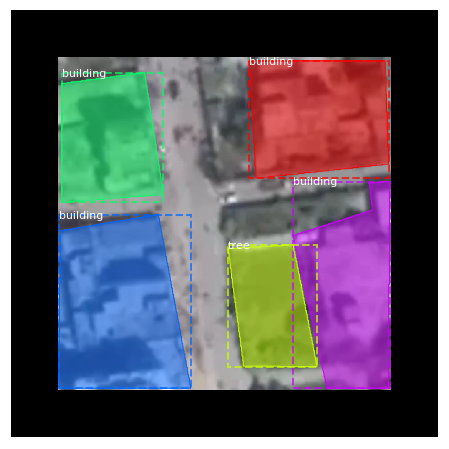

In [ ]:
# Test on a random image
image_id = random.choice(dataset_train.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_train, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  253.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  149.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


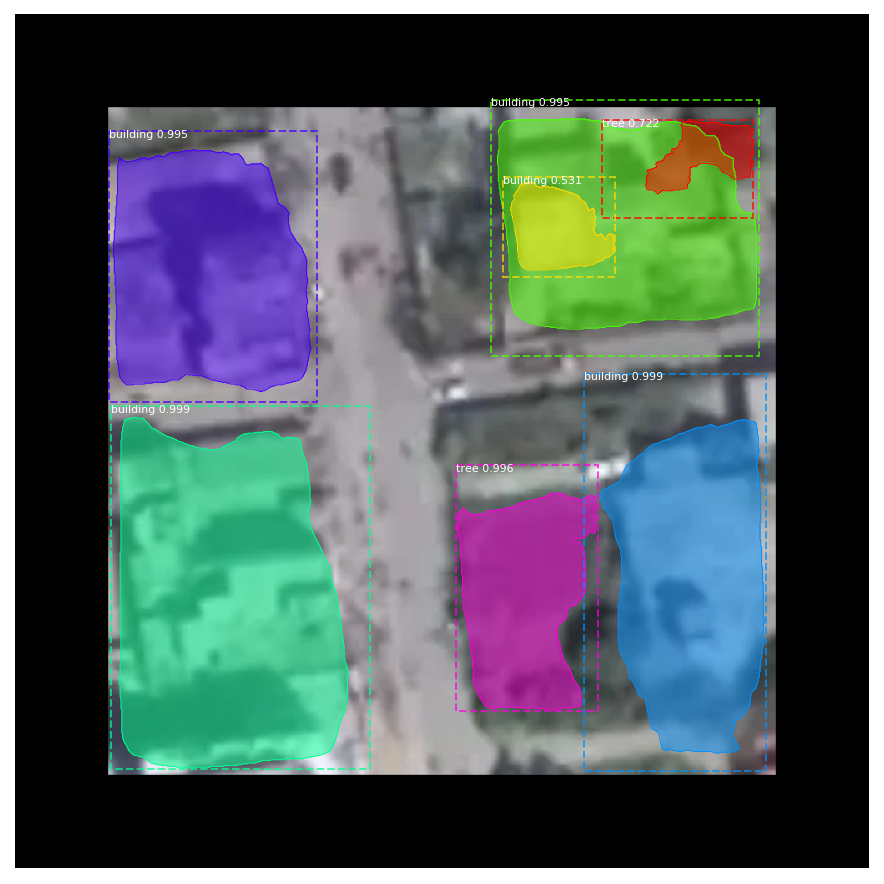

In [ ]:
results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'])

Processing 1 images
image                    shape: (300, 300, 3)         min:    3.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  150.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


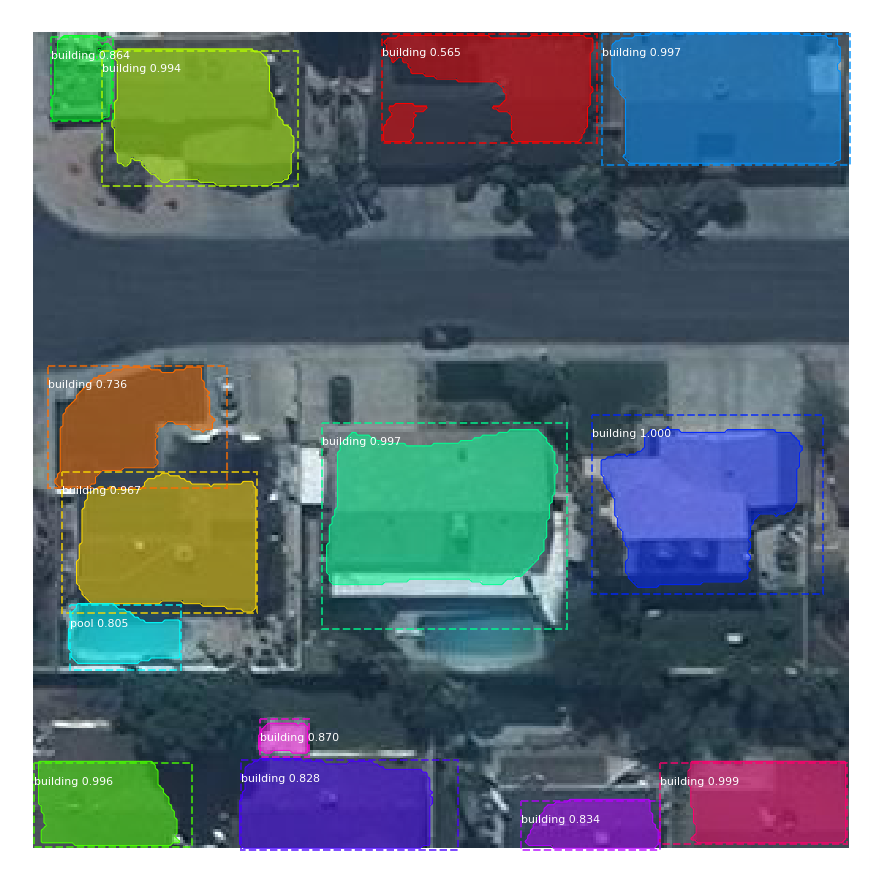

In [ ]:
image_file = "000000000434.jpg"
image = skimage.io.imread(image_file)
r = model.detect([image], verbose=1)[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'])

Processing 1 images
image                    shape: (300, 300, 3)         min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  150.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


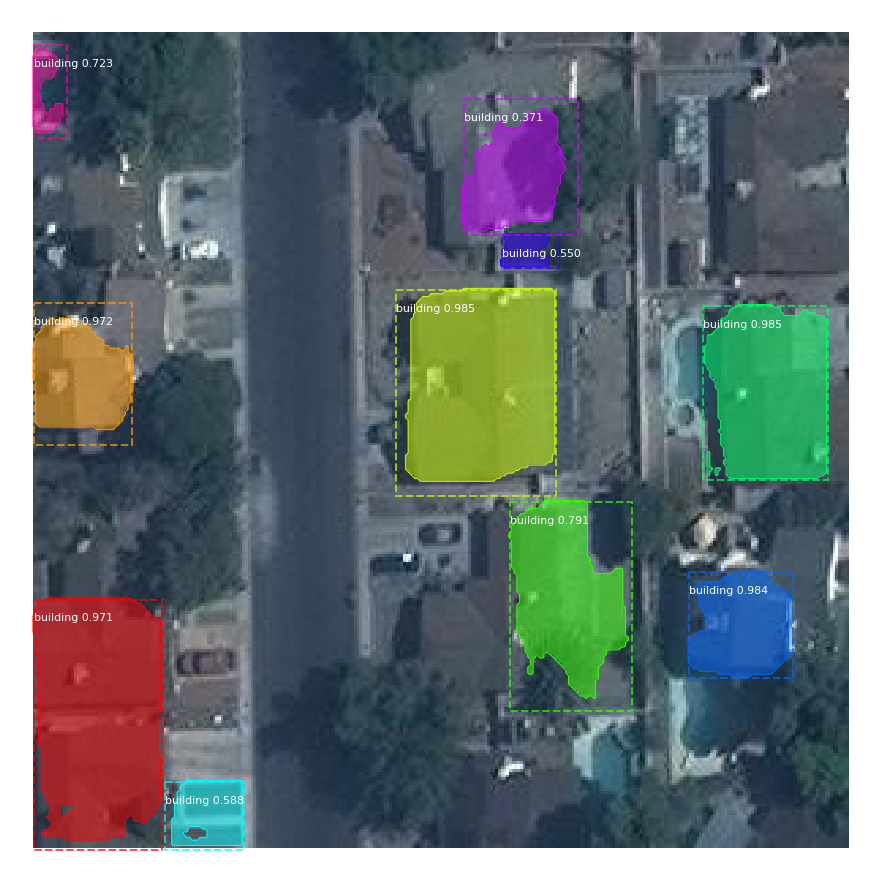

In [ ]:
image_file = "000000000459.jpg"
image = skimage.io.imread(image_file)
r = model.detect([image], verbose=1)[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'])

Processing 1 images
image                    shape: (256, 256, 3)         min:   44.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  139.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


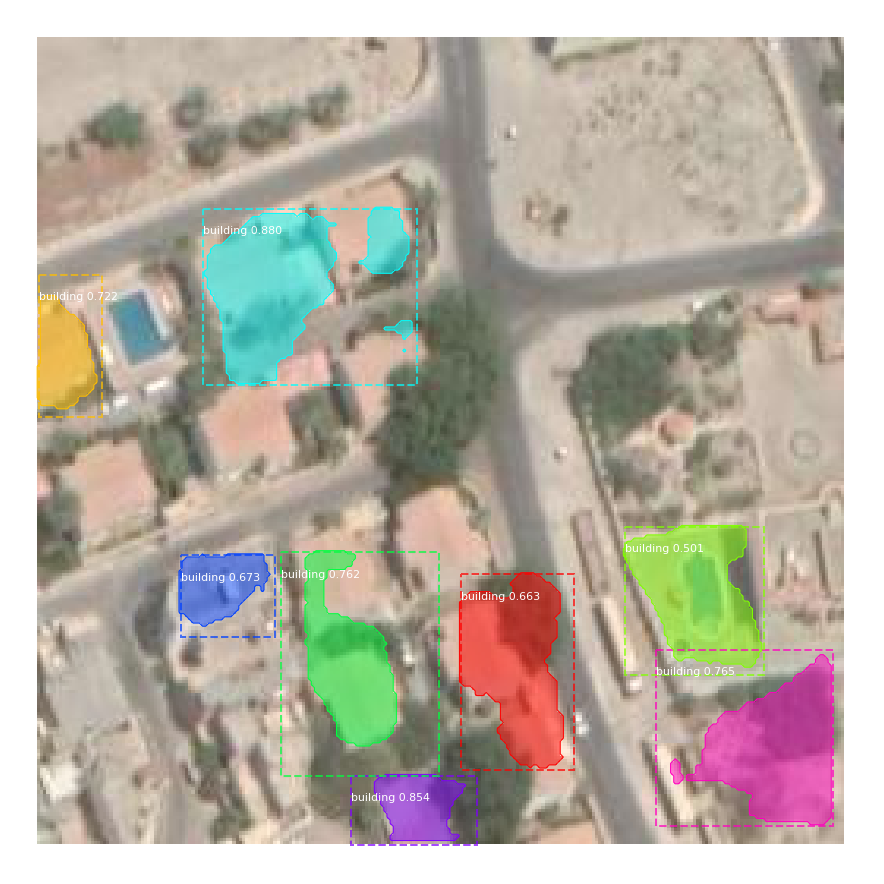

In [ ]:
image_file = "150870.jpg"
image = skimage.io.imread(image_file)
r = model.detect([image], verbose=1)[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'])

In [ ]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
image_ids = np.random.choice(dataset_val.image_ids, 10)
APs = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))

print(len(APs))
print(len(recalls))

mAP:  0.4584986909396118
10
10


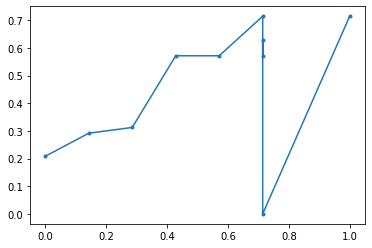

In [ ]:
from sklearn.metrics import precision_recall_curve
from matplotlib import pyplot
pyplot.plot(recalls, APs, marker='.', label='Logistic')